In [1]:
import pandas as pd
import numpy as np
import sweetviz as sv
import os
import matplotlib.pyplot as plt

from count_view_Reaction import *
from step1_to_4 import *

# <span style="color:blue"> Search data on Reaxys </span>

- cyclopentanone → cyclopentanol, map C-carbonyl → give 35,665 reactions
	- exclude NA yield → 5,747 reactions
	- limit to single-step, article -> 4,885 reactions
	- limit to ‘sodium tetrahydroborate’ -> **2,272 reactions**
- cyclohexanone → cyclohexanol, map C-carbonyl → give 61,693 reactions
	- exclude NA yield → 9,765 reactions
	- limit to single-step, article -> 8,502 reactions
	- limit to ‘sodium tetrahydroborate’ -> **3,487 reactions**

*use ‘limit to’ for document type as ‘exclude’ other document type will delete the rxn that has mix document types, which might also contain article .*

# <span style="color:blue"> Import data </span>

- Double check number of reactions

In [2]:
# Change working directory
os.chdir('/Users/suongsuong/Documents/GitHub/Reactivity-based-metric-of-complexity/Reduction of ketone/')

In [3]:
cyclo_concat = pd.read_excel('Reaxys_Raw data/cyclo5,6.xlsx')
count_num_reaction(cyclo_concat)

Number of Reactions: 5421
Number of Rows: 11834


# <span style="color:blue"> EDA </span>
#### view HTML file for EDA result. 

In [4]:
eda = sv.analyze(cyclo_concat)
eda.show_html(filepath='Reaxys_Raw data/EDA_Rawdata_cyclo5,6.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Reaxys_Raw data/EDA_Rawdata_cyclo5,6.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


###  <span style="color:blue"> Step 1: General Cleaning</span>
### <span style="color:blue"> Step 2: Verify reaction by MW</span>
### <span style="color:blue"> Step 3: Verify reaction by change in C-O bonds</span>
### <span style="color:blue"> Step 4: Ensure consistent reaction conditions</span>

In [5]:
cyclo_clean_1_to_4 = step_1_to_4(cyclo_concat)

Data size after step 1 - general cleaning:
Number of Reactions: 2593
Number of Rows: 3468
Data size after step 2 - Verify reaction by change in MW:
Number of Reactions: 2233
Number of Rows: 3027
Data size after step 3 - Verify reaction by change in C-O bond:
Number of Reactions: 2210
Number of Rows: 3000
Data size after step 4 - Ensure consistent reaction conditions:
Number of Reactions: 491
Number of Rows: 533


### <span style="color:blue"> Step 5: Inspect duplicate rows </span>

In [6]:
# Convert columns with lists to tuples
for col in cyclo_clean_1_to_4.columns:
    if cyclo_clean_1_to_4[col].apply(lambda x: isinstance(x, list)).any():
        cyclo_clean_1_to_4[col] = cyclo_clean_1_to_4[col].apply(tuple)

# Drop duplicated rows have every columns are exactly the same
cyclo_remove_duplicate = cyclo_clean_1_to_4.drop_duplicates()

print(count_num_reaction(cyclo_remove_duplicate))

cyclo_remove_duplicate['Reaction ID'].value_counts().head(10)

Number of Reactions: 491
Number of Rows: 500
None


5125708     2
10088666    2
2839467     2
50834932    2
4899473     2
40358815    2
5103599     2
1159290     2
32575260    2
2505975     1
Name: Reaction ID, dtype: int64

In [7]:
#### USE THIS CODE TO EXAMINE THE REACTION

# Reaction_ID = 32575260
# view_reactionScheme(SingleReduc_duplicate[SingleReduc_duplicate['Reaction ID'] == Reaction_ID], 2, 'keep duplicate')
# SingleReduc_duplicate[SingleReduc_duplicate['Reaction ID'] == Reaction_ID]

#### <span style="color:salmon"> Reaction ID = 5125708 </span>
Same reaction, conditions, 2 reported yields (96% vs 96.3%) from 2 references with same title, same authors but published in 2 different years in 2 different journals. 

=> Both were actually 96%. Keep the one having 96% yield

#### <span style="color:salmon"> Reaction ID = 10088666 </span> 
Same reaction, conditions, yield, but different references  

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 2839467 </span> 
Same reaction, conditions, references, yield reported as '29.3 percent; 9 percent' and '29.3 percent; 9.0 percent' 

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 50834932 </span> 
Same reaction, different reacting time with 2 different yields 

1h reaction ~ 94% 

0.5h reaction ~ 96% 

=> take average of the yields

#### <span style="color:salmon"> Reaction ID = 4899473 </span> 
Same reaction, conditions, yield, but 2 references 

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 40358815 </span> 
Same reaction, conditions, yield, but 2 references 

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 5103599 </span> 
Same reaction, different reacting time with 2 different yields 

12h reaction ~ 83% 

0.5h reaction ~ 96.7% 

=> Take average

#### <span style="color:salmon"> Reaction ID = 1159290 </span> 
Same reaction, conditions, 2 references reported 2 different yields

=> Too different. Remove both

#### <span style="color:salmon"> Reaction ID = 32575260 </span> 

Same yield reported (2 references) for same reaction of same reaction conditions.

Check the literatures: the yields are actually 74% and 23% (not 73 and 24) for both. 
Note for later if needed because this difference does not affect the sum for now

=> keep 1, no matter which

#### Based on comments above, handle duplicated rows and update yields. Note for later when verifying reactions with literatures.

In [8]:
id_toremove = [1159290]
id_tokeep1 =[5125708,10088666, 2839467, 50834932, 4899473, 40358815,5103599, 32575260] 

duplicate_rows = cyclo_remove_duplicate[cyclo_remove_duplicate['Reaction ID'].isin(id_tokeep1)].drop_duplicates(subset=['Reaction ID'])

not_duplicate = cyclo_remove_duplicate[~cyclo_remove_duplicate['Reaction ID'].isin(id_tokeep1)]

cyclo_remove_duplicate = pd.concat([duplicate_rows,not_duplicate])

# Update the 'Yield' column for 'Reaction ID' 5125708, 50834932 and 5103599
cyclo_remove_duplicate.loc[cyclo_remove_duplicate['Reaction ID'] == 50834932, 'Yield (number)'] = 96
cyclo_remove_duplicate.loc[cyclo_remove_duplicate['Reaction ID'] == 50834932, 'Yield (number)'] = np.average([94,96])
cyclo_remove_duplicate.loc[cyclo_remove_duplicate['Reaction ID'] == 5103599, 'Yield (number)'] = np.average([83,96.7])

# Remove rows with 'Reaction ID' in id_toremove
cyclo_remove_duplicate = cyclo_remove_duplicate[~cyclo_remove_duplicate['Reaction ID'].isin(id_toremove)]

count_num_reaction(cyclo_remove_duplicate)

Number of Reactions: 490
Number of Rows: 490


#### <span style="color:salmon"> Verify duplicated rows by reaction SMILES </span> 

There are 2 reaction are the same but were assigned to different ID: 48228963 and 48228690
Everything else are the same -> keep 1

In [9]:
cyclo_remove_duplicate['Reaction'].value_counts().head(3)

[H][C@]12CC[C@]3([H])[C@](CC1=C)(C2=O)C(=O)O[C@@]1([H])C[C@@]2([H])O[C@@]4([H])OC[C@@]31[C@@]4([H])C2(C)C>>[H][C@]12OC[C@]34[C@@]1([H])C(C)(C)[C@@]([H])(C[C@]3([H])OC(=O)[C@]13CC(=C)[C@]([H])(CC[C@@]41[H])[C@H]3O)O2    2
COC(=O)[C@]1(O)CC2=CC(Cl)=CC=C2C1=O>>COC(=O)[C@]1(O)CC2=C(C=CC(Cl)=C2)[C@@H]1O                                                                                                                                             1
O=C1CCC[C@@]2(CCCCC2=O)N1>>O[C@H]1CCCC[C@@]11CCCC(=O)N1                                                                                                                                                                    1
Name: Reaction, dtype: int64

In [10]:
cyclo_remove_duplicate = cyclo_remove_duplicate.drop_duplicates( subset = 'Reaction')
count_num_reaction(cyclo_remove_duplicate)

Number of Reactions: 489
Number of Rows: 489


### <span style="color:blue"> Step 6: Manually verify reaction by checking literature </span>

In [11]:
# manually check error data
error_df = pd.read_excel('/Users/suongsuong/Documents/GitHub/Reactivity-based-metric-of-complexity/Reduction of ketone/manually check - 5,6cycloketone.xlsx')
count_num_reaction(error_df)
merged_df = cyclo_remove_duplicate.merge(error_df, on='Reaction ID', how='left')
merged_df['Error'] = merged_df['Error'].fillna('No problem noted')

Number of Reactions: 132
Number of Rows: 132


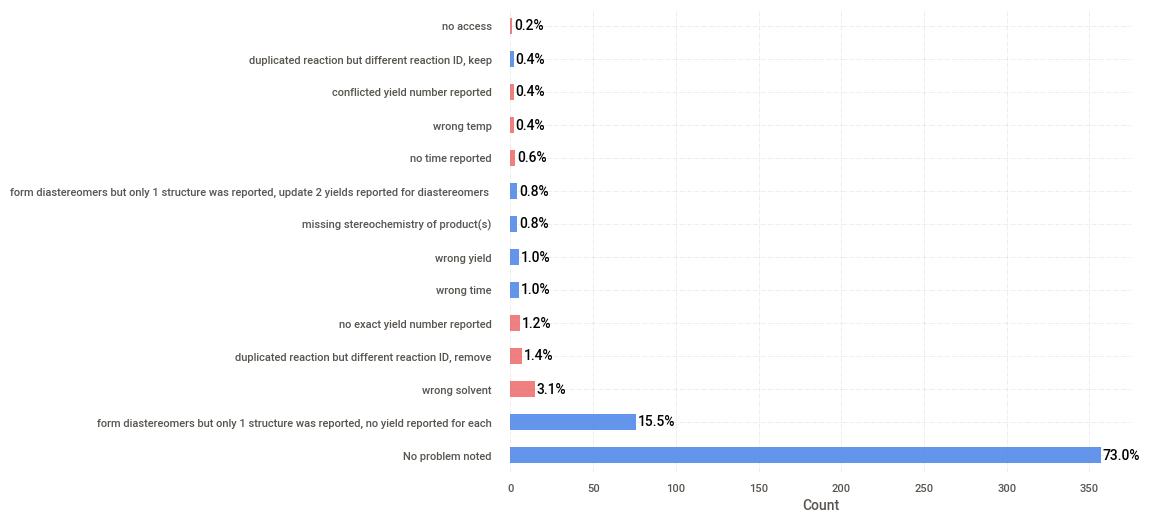

In [12]:
error_counts = merged_df['Error'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
ax = error_counts.plot(kind='barh', color=[
    'lightcoral' if error in [
        'wrong solvent', 'wrong temp', 'duplicated reaction but different reaction ID, remove', 
        'no exact yield number reported', 'no time reported', 
        'conflicted yield number reported', 'no access'
    ] else 'cornflowerblue' for error in error_counts.index
])

# Add labels and percentages
plt.xlabel('Count')
total = sum(error_counts)
for i, count in enumerate(error_counts):
    ax.text(count + 1, i, f'{(count / total * 100):.1f}%', va='center')

# Customize the plot
ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

plt.show()

In [13]:
SingleReduc_manually_update = cyclo_remove_duplicate

# Update
for idx, row in merged_df.iterrows():
    # remove 
    if row['Error'] in ['wrong solvent', 'wrong temp', 'duplicated reaction but different reaction ID, remove', 
        'no exact yield number reported', 'no time reported', 
        'conflicted yield number reported', 'no access']:
        SingleReduc_manually_update = SingleReduc_manually_update.drop(SingleReduc_manually_update[SingleReduc_manually_update['Reaction ID'] == row['Reaction ID']].index)
    elif row['Error'] in ['wrong yield' , 'form diastereomers but only 1 structure was reported, update 2 yields reported for diastereomers']:
        SingleReduc_manually_update.loc[SingleReduc_manually_update['Reaction ID'] == row['Reaction ID'], 'Yield'] = row['actual']
        # update yield (number)
        SingleReduc_manually_update['Yield'] = SingleReduc_manually_update['Yield'].astype(str)
        SingleReduc_manually_update['Yield (number)'] = SingleReduc_manually_update['Yield'].apply(extract_yield)
        SingleReduc_manually_update['Yield (number)'] = pd.to_numeric(SingleReduc_manually_update['Yield (number)'], errors='raise')
    # update time 
    elif row['Error'] == 'wrong time':
        SingleReduc_manually_update.loc[SingleReduc_manually_update['Reaction ID'] == row['Reaction ID'], 'Time (Reaction Details) [h]'] = row['actual']

count_num_reaction(SingleReduc_manually_update)

Number of Reactions: 453
Number of Rows: 453


----------

## <span style="color:blue"> Histogram of Yield (number) </span>

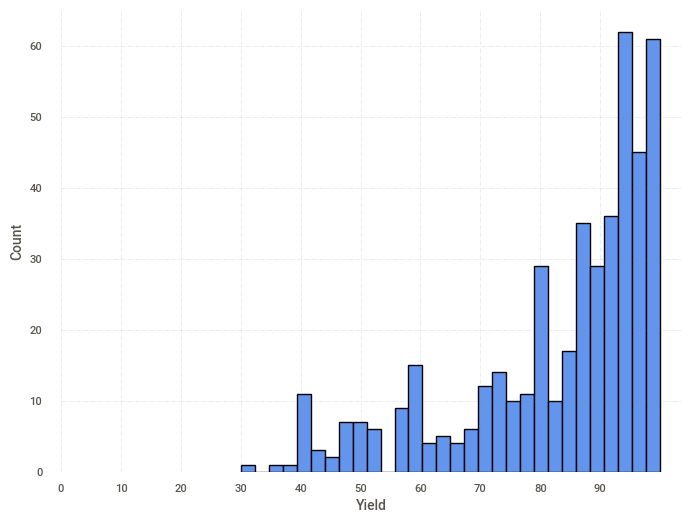

Statistic of Yield:


count    453.000000
mean      83.010375
std       16.247156
min       30.000000
25%       76.000000
50%       89.000000
75%       95.000000
max      100.000000
Name: Yield (number), dtype: float64

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(SingleReduc_manually_update['Yield (number)'], bins=30, color='cornflowerblue', edgecolor='black')
plt.xlabel('Yield')
plt.xticks(np.arange(0, 100, step=10))
plt.ylabel('Count')

# Customize 
ax = plt.gca()  
ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

plt.show()

print('Statistic of Yield:')
SingleReduc_manually_update['Yield (number)'].describe()

---------
#### Save data - cyclo5,6ketone

In [15]:
SingleReduc_manually_update.to_excel('/Users/suongsuong/Documents/GitHub/Reactivity-based-metric-of-complexity/Reduction of ketone/cyclo5,6ketone_final.xlsx', index= False)